# PROBLEM STATEMENT #

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display_html

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# Training dataset
train = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\House Price Prediction\train.csv")

# Prediction Set
p = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\House Price Prediction\test.csv")

**BASIC DATA EXPLORATION**

In [3]:
print("Train Data Size:", train.shape)
print("Test Data Size:", p.shape)

Train Data Size: (1460, 81)
Test Data Size: (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print((train.isnull().sum() / len(train) * 100).sort_values(ascending=False))

PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
FireplaceQu      47.260274
                   ...    
CentralAir        0.000000
SaleCondition     0.000000
Heating           0.000000
TotalBsmtSF       0.000000
Id                0.000000
Length: 81, dtype: float64


In [6]:
print((p.isnull().sum() / len(p) * 100).sort_values(ascending=False))

PoolQC         99.794380
MiscFeature    96.504455
Alley          92.666210
Fence          80.123372
FireplaceQu    50.034270
                 ...    
Electrical      0.000000
CentralAir      0.000000
HeatingQC       0.000000
Foundation      0.000000
Id              0.000000
Length: 80, dtype: float64


In [7]:
print(train["SalePrice"].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [8]:
print(train["SalePrice"].skew(), train["SalePrice"].kurtosis())

1.8828757597682129 6.536281860064529


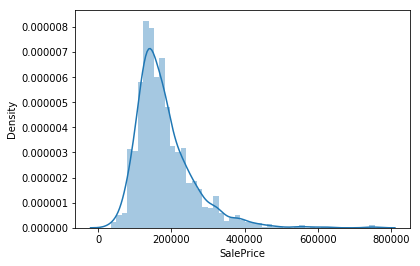

In [9]:
sns.distplot(train["SalePrice"])
plt.show()

# Target Variable has a positive skew ; 

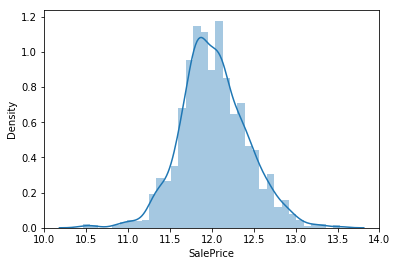

In [10]:
train["SalePrice"] = np.log(train["SalePrice"])
sns.distplot(train["SalePrice"])
plt.show()

**BASELINE MODEL**

In [11]:
# We will set up a baseline model for benchmarking future models;

def baseline(m):
    y_b = m.pop("SalePrice")
    x_b = m.drop(["Id"], axis=1)
    x_b = x_b.fillna(0)
    x_b = pd.get_dummies(x_b)
    
    base = XGBRegressor()
    
    score = cross_val_score(base,x_b,y_b,cv=5, scoring = "neg_mean_squared_error")
    score = -1*score.mean()
    score = np.sqrt(score)
    return score
    
base_Data = train.copy()
print("Baseline Model Error:", baseline(base_Data))

Baseline Model Error: 0.1406686351043878


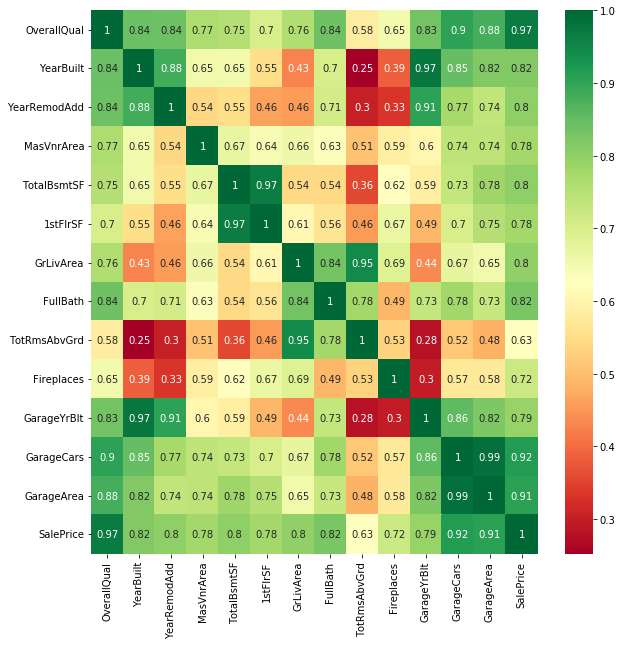

In [12]:
# Correlation - Coefficient

corr = train.corr()
strongest_corr = corr.index[abs(corr["SalePrice"]) > 0.4 ]
plt.figure(figsize=(10,10))
sns.heatmap(corr[strongest_corr].corr(), annot = True, cmap = 'RdYlGn');

**MultiCollinearity - Some of the independent variables have high correlation between them**

With 0.95 as a cutoff we can eliminate a few variables. We will choose the one with higher corr with Saleprice between mulitcollinear variables.

1. TotalBsmtSF & 1stFlrSF
2. GrLivArea & TotalRoomsAbvGrd
3. Garage Cars & Garage Area

In [13]:
train.drop(["1stFlrSF","TotRmsAbvGrd","GarageArea"], axis=1, inplace=True)
p.drop(["1stFlrSF","TotRmsAbvGrd","GarageArea"], axis=1, inplace=True)

In [14]:
print(corr["SalePrice"].sort_values(ascending= False)[:5],'\n')
print(corr["SalePrice"].sort_values(ascending= False)[-5:])

SalePrice      1.000000
OverallQual    0.817184
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
Name: SalePrice, dtype: float64 

YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64


**DATA VISUALIZATION**

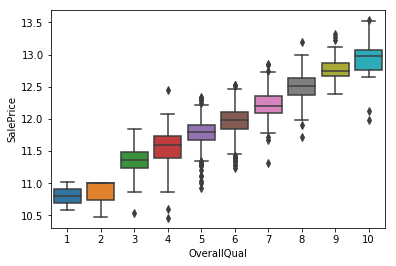

In [15]:
sns.boxplot(y= train['SalePrice'], x = train['OverallQual'])
plt.show()

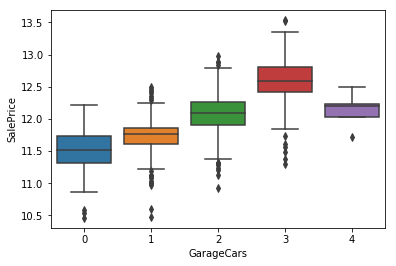

In [16]:
sns.boxplot(y= train['SalePrice'], x = train['GarageCars'])
plt.show()

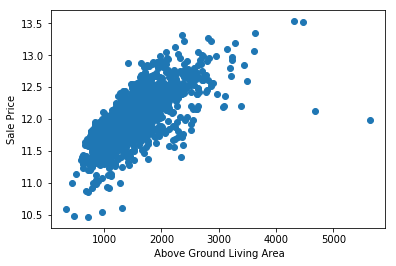

In [17]:
plt.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.xlabel(" Above Ground Living Area")
plt.ylabel("Sale Price")
plt.show()

**The key attributes that SalePrice seems to depend on are Overall Quality of House, Garage attributes and Above Ground Living Area. We will utilize this information to create additional features using these**

In [18]:
train["MSSubClass"] = train["MSSubClass"].astype("object")
p["MSSubClass"] = p["MSSubClass"].astype("object")

train["MoSold"] = train["MoSold"].astype("object")
p["MoSold"] = p["MoSold"].astype("object")

nvar = train.columns[train.dtypes != "object"]
cvar = train.columns[train.dtypes == "object"]

In [19]:
train[nvar].isnull().sum().sort_values(ascending = False)

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
BsmtFinSF1         0
LowQualFinSF       0
2ndFlrSF           0
TotalBsmtSF        0
BsmtUnfSF          0
BsmtFinSF2         0
SalePrice          0
BsmtFullBath       0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
LotArea            0
GrLivArea          0
BsmtHalfBath       0
YrSold             0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
Fireplaces         0
GarageCars         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
Id                 0
dtype: int64

In [20]:
p[p.columns[p.dtypes != "object"]].isnull().sum().sort_values(ascending = False)

LotFrontage      227
GarageYrBlt       78
MasVnrArea        15
BsmtFullBath       2
BsmtHalfBath       2
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
GarageCars         1
LowQualFinSF       0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
LotArea            0
2ndFlrSF           0
YrSold             0
GrLivArea          0
MiscVal            0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
Fireplaces         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
Id                 0
dtype: int64

In [21]:
train[cvar].isnull().sum().sort_values(ascending = False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageCond         81
GarageQual         81
GarageFinish       81
GarageType         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrType          8
Electrical          1
Utilities           0
LotConfig           0
LandContour         0
RoofStyle           0
LotShape            0
Street              0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
MSZoning            0
BldgType            0
HouseStyle          0
SaleCondition       0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
SaleType            0
Heating             0
HeatingQC           0
CentralAir          0
KitchenQual         0
Functional          0
PavedDrive          0
MoSold              0
MSSubClass          0
dtype: int

In [22]:
p[cvar].isnull().sum().sort_values(ascending = False)

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
GarageCond         78
GarageQual         78
GarageFinish       78
GarageType         76
BsmtCond           45
BsmtQual           44
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
MasVnrType         16
MSZoning            4
Utilities           2
Functional          2
Exterior1st         1
Exterior2nd         1
KitchenQual         1
SaleType            1
Neighborhood        0
Condition1          0
LotShape            0
LandSlope           0
LotConfig           0
LandContour         0
BldgType            0
Street              0
Condition2          0
SaleCondition       0
HouseStyle          0
RoofStyle           0
RoofMatl            0
ExterQual           0
ExterCond           0
Foundation          0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
PavedDrive          0
MoSold              0
MSSubClass          0
dtype: int

 **We have lots of missing values we have to take care of;**

We will first divide the dataset into train set and a testing set (will be used to evaluate model performance on unseen data).We will handle the numerical missing values in both train and test set and then move on to categorical missing variables.

In [23]:
y = train["SalePrice"]
x = train.drop(["SalePrice"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20, random_state = 42)

In [24]:
lf_median = x_train["LotFrontage"].median()


x_train["LotFrontage"].fillna(lf_median,inplace=True)
x_test["LotFrontage"].fillna(lf_median,inplace=True)
p["LotFrontage"].fillna(train["LotFrontage"].median(),inplace=True)

In [25]:
# Garage Year Built Missing Values. These are likely to be missing as the house probably doesnt have a garage;
x_train.loc[x_train.GarageYrBlt.isna()][["GarageCond","GarageQual","GarageFinish"]]

,GarageCond,GarageQual,GarageFinish
638,NaN,NaN,NaN
210,NaN,NaN,NaN
48,NaN,NaN,NaN
155,NaN,NaN,NaN
1030,NaN,NaN,NaN
...,...,...,...
520,NaN,NaN,NaN
241,NaN,NaN,NaN
562,NaN,NaN,NaN
1337,NaN,NaN,NaN


In [26]:
# Masonry Veneer Area. It is missing since it has no masonry veneer;
x_train.loc[x_train.MasVnrArea == 0]["MasVnrType"]

254     None
1066    None
638     None
380     None
303     None
        ... 
1044    None
1095    None
1130    None
1294    None
860     None
Name: MasVnrType, Length: 674, dtype: object

In [27]:
x_train.MasVnrArea.fillna(0,inplace=True)
x_test.MasVnrArea.fillna(0,inplace=True)
p.MasVnrArea.fillna(0,inplace=True)

All train numerical missing variables except Garage Year Built (we will use it later to create a feature) have been handled. Since the count of missing numerical variables in prediction dataset are very small in number, we will just fill in with zero's.

In [28]:
cols = ["BsmtHalfBath","BsmtFullBath","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","GarageCars"]

for col in cols:
    p[col].fillna(0,inplace=True)

In [29]:
# Filling Categorical Missing Variables; Will drop features missing more than 80% of data;

x_train.drop(["PoolQC","Alley","Fence","MiscFeature"],axis=1,inplace=True)
x_test.drop(["PoolQC","Alley","Fence","MiscFeature"],axis=1,inplace=True)
p.drop(["PoolQC","Alley","Fence","MiscFeature"],axis=1,inplace=True)

In [30]:
# FireplaceQuality

train.loc[train.FireplaceQu.isna()]["Fireplaces"].value_counts()

0    690
Name: Fireplaces, dtype: int64

In [31]:
x_train["FireplaceQu"].fillna("NA",inplace=True)
x_test["FireplaceQu"].fillna("NA",inplace=True)
p["FireplaceQu"].fillna("NA",inplace=True)

In [32]:
# Garage characteristics
cols = ["GarageType","GarageCond","GarageQual","GarageFinish"]

for col in cols:
    x_train[col].fillna('NA',inplace=True)
    x_test[col].fillna('NA',inplace=True)
    p[col].fillna('NA',inplace=True)

In [33]:
# Basement Characteristics

co = ["BsmtCond","BsmtQual","BsmtExposure","BsmtFinType1","BsmtFinType2"]

for col in co:
    x_train[col].fillna('NA',inplace=True)
    x_test[col].fillna('NA',inplace=True)
    p[col].fillna('NA',inplace=True)

x_train["Electrical"].fillna('Mix',inplace=True)
x_test["Electrical"].fillna('Mix',inplace=True)
p["MasVnrType"].fillna("None",inplace=True)

In [34]:
p["MasVnrType"].fillna('None',inplace=True)
p["Utilities"].fillna(train["Utilities"].mode()[0],inplace=True)
p["Functional"].fillna(train["Functional"].mode()[0],inplace=True)
p["Exterior1st"].fillna(train["Exterior1st"].mode()[0],inplace=True)
p["Exterior2nd"].fillna(train["Exterior2nd"].mode()[0],inplace=True)
p["KitchenQual"].fillna(train["KitchenQual"].mode()[0],inplace=True)
p["MSZoning"].fillna(train["MSZoning"].mode()[0],inplace=True)
p["SaleType"].fillna("Oth",inplace=True)

** OUTLIER FIXING,FEATURE ENGINEERING**

In [35]:
# Fixing outliers with capping method;

num_feats = x_train.columns[x_train.dtypes != 'object']

for col in num_feats:
    
    q1 = x_train[col].quantile(0.25)
    q3 = x_train[col].quantile(0.75)
    iqr = q3 - q1
    
    x_train.loc[x_train[col] > q3 + 1.5*iqr, col] = q3
    x_test.loc[x_test[col] > q3 + 1.5*iqr, col] = q3
    p.loc[p[col] > q3 + 1.5*iqr, col] = q3
    
    x_train.loc[x_train[col] < q1 - 1.5*iqr, col] = q1
    x_test.loc[x_test[col] < q1 - 1.5*iqr, col] = q1
    p.loc[p[col] < q1 - 1.5*iqr, col] = q1
    

**Handling Numerical Variables**

In [36]:
x_train["GarageYrBlt"].fillna(0, inplace = True)
x_test["GarageYrBlt"].fillna(0, inplace = True)
p["GarageYrBlt"].fillna(0, inplace = True)

Some features have wrong datatypes and some features have different datatypes in train and prediciton set. We will make these consistent; Features like area will be cast to float datatype while while year, count etc will be set to integer. We will make these corrections before creating new features.

In [37]:
area = ["LotArea",'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
      'TotalBsmtSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
      'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MasVnrArea']

yc = ['GarageYrBlt','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars',]

In [38]:
x_train[area] = x_train[area].astype('float64')
x_train[yc] = x_train[yc].astype('int64')

x_test[area] = x_test[area].astype('float64')
x_test[yc] = x_test[yc].astype('int64')

p[area] = p[area].astype('float64')
p[yc] = p[yc].astype('int64')

In [39]:
def numfeatures(x):
    
    x["House Rating"] = x["OverallQual"] * x["OverallCond"] / 10
    x["House_Oldness"] = x["YrSold"] - x["YearBuilt"]
    x["Year_SR"] = x["YrSold"] - x["YearRemodAdd"]
    x["Bsmtfin"] = x["BsmtFinSF1"] + x["BsmtFinSF2"]
    x["Total_HouseSF"] = x["GrLivArea"] + x["TotalBsmtSF"]
    x["LivLotRatio"] = x["GrLivArea"] / x["LotArea"]
    x["TotalPorchSF"] = x["OpenPorchSF"] + x["EnclosedPorch"] + x["3SsnPorch"] + x["ScreenPorch"]
    x["Partial_Sale"] = x["SaleCondition"].apply(lambda x: 1 if x == 'Partial' else 0)
    x = x.drop(["Id"],axis=1)
    return x

x_train = numfeatures(x_train)
x_test = numfeatures(x_test)
p = numfeatures(p)

In [40]:
# Mutual Info Method to find out feature importance
from sklearn.feature_selection import mutual_info_regression

mi_data = x_train.copy()

y_mi = y_train
x_mi  = mi_data[mi_data.columns[mi_data.dtypes != 'object']]

mx_train, mx_test,my_train,my_test = train_test_split(x_mi,y_mi,test_size=0.25)

mutual_info = mutual_info_regression(mx_train,my_train)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mx_train.columns

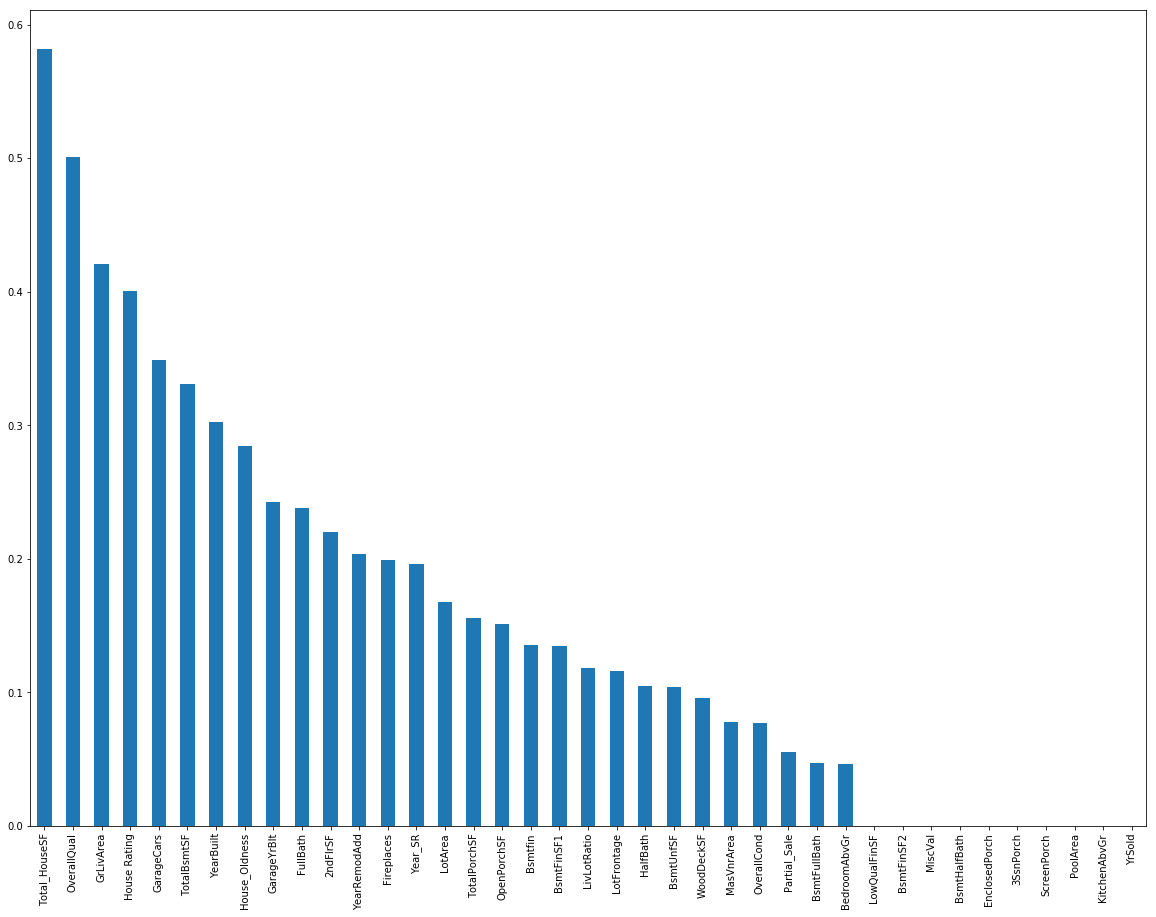

In [41]:
mutual_info.sort_values(ascending = False).plot.bar(figsize=(20,15))
plt.show()

In [42]:
from sklearn.feature_selection import SelectKBest, SelectPercentile

top_features = SelectPercentile(mutual_info_regression, percentile = 10)
top_features.fit(mx_train,my_train)
mx_train.columns[top_features.get_support()]

Index(['OverallQual', 'GrLivArea', 'House Rating', 'Total_HouseSF'], dtype='object')

In [43]:
weak_features = mutual_info.index[mutual_info < 0.1 ]

x_train.drop(weak_features,axis=1,inplace=True)
x_test.drop(weak_features,axis=1,inplace=True)
p.drop(weak_features,axis=1,inplace=True)

**Handling Categorical Variables**

1. Some features have high cardinality.
2. Some features have ordered relationships and other do not.

**Ordinal Encoding**

In [44]:
non_ordinal = ['MSSubClass', 'MSZoning', 'Street', 'LandContour',
       'LotConfig','Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation','Heating',
       'GarageType', 
       'MoSold', 'SaleType', 'SaleCondition']

ordinal = ['LotShape','LandSlope','ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','BsmtExposure',
           'BsmtFinType1','BsmtFinType2',
           'HeatingQC',
           'KitchenQual','Functional','FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'CentralAir', 'Electrical', 'Utilities']

In [45]:
print(len(non_ordinal))
print(len(ordinal))
print(len(x_train.columns[x_train.dtypes == 'object']))

21
20
41


In [46]:
cat_train = []
for obj in ordinal:
    cat_train.append(x_train[obj].unique())

In [47]:
cat_train

[array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['TA', 'Gd', 'Ex', 'Fa'], dtype=object),
 array(['Gd', 'TA', 'Ex', 'Fa', 'Po'], dtype=object),
 array(['TA', 'Gd', 'Fa', 'NA', 'Ex'], dtype=object),
 array(['TA', 'Fa', 'NA', 'Gd', 'Po'], dtype=object),
 array(['No', 'Av', 'Gd', 'Mn', 'NA'], dtype=object),
 array(['Rec', 'Unf', 'ALQ', 'LwQ', 'BLQ', 'GLQ', 'NA'], dtype=object),
 array(['Unf', 'LwQ', 'Rec', 'BLQ', 'NA', 'GLQ', 'ALQ'], dtype=object),
 array(['TA', 'Gd', 'Ex', 'Fa', 'Po'], dtype=object),
 array(['TA', 'Gd', 'Ex', 'Fa'], dtype=object),
 array(['Typ', 'Min2', 'Min1', 'Maj2', 'Mod', 'Maj1', 'Sev'], dtype=object),
 array(['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object),
 array(['RFn', 'NA', 'Unf', 'Fin'], dtype=object),
 array(['TA', 'NA', 'Po', 'Fa', 'Gd', 'Ex'], dtype=object),
 array(['TA', 'NA', 'Po', 'Fa', 'Gd', 'Ex'], dtype=object),
 array(['Y', 'P', 'N'], dtype=object),
 array(['Y', 'N'], dtype=object),
 array(['SBr

For ordinal encoding we need to rearrange the categories in descending order of importance.Some of the category orders are jumbled, which we have to update manually.

In [48]:
from sklearn.preprocessing import OrdinalEncoder

In [49]:
oe = OrdinalEncoder([["IR3","IR2","IR1","Reg"],
                       ["Sev", "Mod", "Gtl"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA", "No", "Mn", "Av","Gd"],
                       ["NA","Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                       ["NA","Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["Sal","Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA","Unf","RFn","Fin" ],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ["NA","Po", "Fa", "TA", "Gd", "Ex"],
                       ['N', 'P', 'Y'],
                       ["N", "Y"],
                       ["Mix","FuseP","FuseF","FuseA","SBrkr"],
                       ["ELO", "NoSeWa", "NoSewr", "AllPub"]], dtype ='int64'
                      )
oe.fit(x_train[ordinal]) 

OrdinalEncoder(categories=[['IR3', 'IR2', 'IR1', 'Reg'], ['Sev', 'Mod', 'Gtl'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'No', 'Mn', 'Av', 'Gd'],
                           ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                           ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1',
                            'Typ'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Unf', 'RFn', 'Fin'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
              

In [50]:
x_train[ordinal] = pd.DataFrame(oe.transform(x_train[ordinal]))
x_test[ordinal] = pd.DataFrame(oe.transform(x_test[ordinal]))
p[ordinal] = pd.DataFrame(oe.transform(p[ordinal]))

**One - Hot Encoding**

In [51]:
# One-hot encoding these features

oh = OneHotEncoder(dtype = 'int64', handle_unknown = 'ignore')

features = x_train.columns[x_train.dtypes == 'object']

oh.fit(x_train[features])

OneHotEncoder(dtype='int64', handle_unknown='ignore')

In [52]:
x_train_enc = pd.DataFrame(oh.transform(x_train[features]).toarray())
x_test_enc = pd.DataFrame(oh.transform(x_test[features]).toarray())

p_enc = pd.DataFrame(oh.transform(p[features]).toarray())

In [53]:
x_train.drop(x_train[features],axis=1,inplace=True)
x_test.drop(x_test[features],axis=1,inplace=True)
p.drop(p[features],axis=1,inplace=True)

In [54]:
x_train_final = x_train.join(x_train_enc)
x_test_final = x_test.join(x_test_enc)
p_final = p.join(p_enc)

In [55]:
print(x_train_final.shape,'\n')
print(x_test_final.shape,'\n')
print(p_final.shape,'\n')

(1168, 224) 

(292, 224) 

(1459, 224) 



**Setting a variance threshold to filter out features with low variance in their data**

In [56]:
from sklearn.feature_selection import VarianceThreshold

In [57]:

vt_x = x_train_final
vt_y = y_train

vx_train, vx_test,vy_train,vy_test = train_test_split(vt_x,vt_y,test_size=0.25)


v = VarianceThreshold(threshold = 0.005)
v.fit(vx_train)

VarianceThreshold(threshold=0.005)

In [58]:
low_variance_col = [feature for feature in vt_x.columns
                    if feature not in vt_x.columns[v.get_support()]]

x_train_final = x_train_final.drop(low_variance_col, axis = 1)
x_test_final = x_test_final.drop(low_variance_col, axis = 1)
p_final = p_final.drop(low_variance_col,axis=1)

In [59]:
print(x_train_final.shape,'\n')
print(x_test_final.shape,'\n')
print(p_final.shape,'\n')

(1168, 179) 

(292, 179) 

(1459, 179) 



 **MODEL**

In [60]:
from sklearn.model_selection import RandomizedSearchCV

optimization_data = x_train_final

y = y_train
x = optimization_data


XGB = XGBRegressor()


In [61]:
# Parameters for tuning the model;

n_estimators = [500 , 1000, 1500 , 2000]
max_depth = [2, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.15, 0.2]
min_child_weight = [1, 2, 3, 4]


hyperparameter = {'n_estimators' : n_estimators,
                 'max_depth' : max_depth,
                 'learning_rate' : learning_rate,
                 'min_child_weight' : min_child_weight}

In [62]:
random_cv = RandomizedSearchCV(estimator = XGB, param_distributions = hyperparameter, cv = 5,
                              n_iter = 10, scoring = 'neg_mean_squared_error', n_jobs = 4,
                              verbose = 5, return_train_score = True, random_state = 42)

In [63]:
random_cv.fit(x,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [64]:
random_cv.best_params_

{'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 10,
 'learning_rate': 0.1}

In [66]:
# Updating model with new parameters

XGB_optimized = XGBRegressor(n_estimators = 1000,min_child_weight = 2,max_depth = 10,learning_rate = 0.1)
XGB_optimized.fit(x_train_final,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [67]:
# Cross Validation Score of updated model;


xgb_score = cross_val_score(XGB_optimized,x_train_final,y_train,cv=5, scoring = "neg_mean_squared_error")
xgb_score = -1 * xgb_score.mean()
xgb_score = np.sqrt(xgb_score)

print("XGB :", xgb_score,'\n')

XGB : 0.14657246133615318 



In [68]:
# Performance on model on unknown data

print(np.sqrt(mean_squared_error(XGB_optimized.predict(x_test_final), y_test)))

0.1517289500376987


In [69]:
# Prediction and output generation;

Price = np.floor(np.exp(XGB_optimized.predict(p_final)))

pset = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\House Price Prediction\test.csv")

output = pd.DataFrame({'Id': pset['Id'],
                      'SalePrice' : Price})

output.to_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\House Price Prediction\pred.csv",index=False)